<!--HEADER-->
*Tutorial sobre Flux.jl - 2020/2 [- Ricardo M. S. Rosa (IM/UFRJ)](http://www.im.ufrj.br/rrosa)*

<!--BADGES-->
<a href="https://nbviewer.jupyter.org/github/rmsrosa/TutorialFlux/blob/main/notebooks/06.00-Metodos_treinamento.ipynb" target="_blank"><img align="left" src="https://img.shields.io/badge/view%20in-nbviewer-orange" alt="View in NBViewer" title="View in NBViewer"></a><a href="https://mybinder.org/v2/gh/rmsrosa/TutorialFlux/julia-env-for-binder?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Frmsrosa%252FTutorialFlux%26branch%3Dmain%26urlpath%3Dtree%252FTutorialFlux%252Fnotebooks/06.00-Metodos_treinamento.ipynb" target="_blank"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open in binder"></a><a href="https://nbviewer.jupyter.org/github/rmsrosa/TutorialFlux/blob/main/notebooks/slides/06.00-Metodos_treinamento.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/view-slides-darkgreen" alt="View Slides" title="View Slides"></a>&nbsp;

<!--NAVIGATOR-->
[<- 5. Treinando redes neurais](05.00-Treinando_redes_neurais.ipynb) | [Página inicial](00.00-Pagina_inicial.ipynb) | [7. Identificação de dígitos com os dados MNIST ->](07.00-Reconhecimento_digitos.ipynb)

---


# Métodos de treinamento

* O que o `Flux.train!` faz é apenas executar um passo de um dado algoritmo de otimização.

* Vamos ver detalhes do `Flux.train!`.

* Assim como as opções de algoritmos.

In [1]:
using Flux
using Random
using IterTools: ncycle
using Plots

## `Flux.train!`

* O `Flux.train!` é parte do módulo [Flux.Optimise](https://github.com/FluxML/Flux.jl/blob/master/src/optimise/Optimise.jl).

* Vejamos o [código do `Flux.train!`](https://github.com/FluxML/Flux.jl/blob/master/src/optimise/train.jl#L96):

```julia
function train!(loss, ps, data, opt; cb = () -> ())
  ps = Params(ps)
  cb = runall(cb)
  @progress for d in data
    try
      gs = gradient(ps) do
        loss(batchmemaybe(d)...)
      end
      update!(opt, ps, gs)
      cb()
    catch ex
      if ex isa StopException
        break
      elseif ex isa SkipException
        continue
      else
        rethrow(ex)
      end
    end
  end
end
```

### Detalhes

* [Params](https://github.com/FluxML/Zygote.jl/blob/master/src/compiler/interface.jl#L67) e [gradient](https://github.com/FluxML/Zygote.jl/blob/master/src/compiler/interface.jl#L57) são importados do [FluxML/Zygote.jl](https://github.com/FluxML/Zygote.jl), que é um pacote de **diferenciação automática**.

* `Params` é um tipo composto que guarda quais parâmetros e em que ordem devemos diferenciar uma função

* `params`, utilizado no treinamento visto anteriormente, define quais parâmetros serão considerados para a diferenciação.

* `gradient` calcula o gradiente de uma função, em relação aos parâmetros dados, via diferenciação automática.

* `gradient` usa `backwards propagation` (veja o uso de `pullback(f, args...)` na sua definição).

* **Observação:** Podemos "pular" o `Flux.train!` e escrever métodos de otimização com outros métodos de diferenciação, como `ForwardDiff` (forwards propagation) e `ReverseDiff` (backward mas mais genérico e não tão eficiente quando o `gradient` no caso de redes neurais em questão). Leia mais sobre isso e sobre outros pacotes em [JuliaDiff](https://juliadiff.org).

### Atalho para uma sequência de treinos

* É comum vermos o uso de 

```julia
@epochs N train!(...)
```

* Isso é apenas um atalho para um loop com a exibição de época a cada iteração:

```julia
for i=1:N
    train!(...)
end
```

### Callbacks

* O parâmetro de `callback` pode ser muito útil para
    * exibir informações sobre determinados passos do *loop* de treinamento.
    * Registrar o custo/perda a cada passo para posterior exibição e avaliação.
    * afetar o treinamento de alguma forma:
        * interromper quando um determinada acurácia é alcançada;
        * interromper quando um limite de iterações ou de tempo é alcançado;
        * trocar os parâmetros correntes de busca caso o treinamente não esteja indo com muito sucesso;
        * substituir, acrescentar ou retirar determinados parâmetros do processo de treinamento;
        * validar o treinamento de acordo com outra amostra de dados;
        * etc.

* Vale lembrar que `callbacks` estão presentes em outros pacotes também, como `DifferentialEquations`, etc., para executar alguma instrução no meio de algum outro processo (e.g. resolução de uma EDO).

* O *Callback* é uma *keyword*, ou seja, é preciso passar como `cb = funcao_de_callback`, exceto que, no Julia 1.6, se a própria função tiver o nome da *keyword*, i.e. `cb`, no caso, e se usarmos `;` para separar os argumentos do tipo keyword dos anteriores, então podemos passá-la direto como `Flux.train!(loss, ps, data, opt; cb)`.

* Veja mais em [Callback Helpers](https://fluxml.ai/Flux.jl/stable/utilities/#Callback-Helpers-1).

## Inicialização das camadas

* A inicialização das camadas é um ponto importante do processo.

* Isso é particularmente importante em camadas convolucioais ou recorrentes.

* Por *default*, `Flux.jl` inicializa essas camadas com o método `Flux.glorot_uniform`.

* Outros métodos estão disponíveis: `glorot_normal`, `kalman_uniform`, `kalman_normal`.

* Esses métodos de inicialização geram parâmetros do tipo `Float32`! Por questões de otimização para GPU (que são de 32-bits).

* Em algumas situações, caso a camada esteja como `Float32`, podemos ter erros (e.g. com `RNN`) ou avisos de "lentidão no processamento" (e.g. com `Conv`) ao aplicamos a rede à um vetor do tipo `Float64`.

* É possível, no entanto, definir camadas com parâmetros do tipo `Float64` (ou outro qualquer) fornecendo diretamento os parâmetros (e.g. `m = Dense(rand(3,2))`, ou um método de inicialização (e.g. `m = Dense(2,3, init=rand)`).

* Outra opção é converter todos os parâmetros de uma camada ou de uma rede `m` para `Float64` com o comando `m = fmap(f64, m)`. A função `f64` do `Flux` converte os parâmetros para `Float64` e a função `fmap`, também do pacote [FluxML/Functors.jl](https://github.com/FluxML/Functors.jl), mapeia todos os parâmetros de volta para a camada/rede.

* Mais sobre isso em [Layer Initialization](https://fluxml.ai/Flux.jl/stable/utilities/#Layer-Initialization-1).

## Funções de custo/perda/objetivo

* Nos exemplos feitos até agora, usamos o **erro quadrático médio** `Flux.Losses.mse`.

* Outras funções de custo são oferecidas no módulo `Flux.Losses` do `Flux.jl`.
    * [mae](https://fluxml.ai/Flux.jl/stable/models/losses/#Flux.Losses.mae)
    * [mse](https://fluxml.ai/Flux.jl/stable/models/losses/#Flux.Losses.mse)
    * [msle](https://fluxml.ai/Flux.jl/stable/models/losses/#Flux.Losses.msle)
    * [huber_loss](https://fluxml.ai/Flux.jl/stable/models/losses/#Flux.Losses.huber_loss)
    * [crossentropy](https://fluxml.ai/Flux.jl/stable/models/losses/#Flux.Losses.crossentropy)
    * [logitcrossentropy](https://fluxml.ai/Flux.jl/stable/models/losses/#Flux.Losses.logitcrossentropy)
    * [binarycrossentropy](https://fluxml.ai/Flux.jl/stable/models/losses/#Flux.Losses.binarycrossentropy)
    * [logitbinarycrossentropy](https://fluxml.ai/Flux.jl/stable/models/losses/#Flux.Losses.logitbinarycrossentropy)
    * [kldivergence](https://fluxml.ai/Flux.jl/stable/models/losses/#Flux.Losses.kldivergence)
    * [poisson_loss](https://fluxml.ai/Flux.jl/stable/models/losses/#Flux.Losses.poisson_loss)
    * [hinge_loss](https://fluxml.ai/Flux.jl/stable/models/losses/#Flux.Losses.hinge_loss)
    * [squared_hinge_loss](https://fluxml.ai/Flux.jl/stable/models/losses/#Flux.Losses.squared_hinge_loss)
    * [dice_coeff_loss](https://fluxml.ai/Flux.jl/stable/models/losses/#Flux.Losses.dice_coeff_loss)
    * [tversky_loss](https://fluxml.ai/Flux.jl/stable/models/losses/#Flux.Losses.tversky_loss)

* Veja detalhes em [Flux.Losses](https://fluxml.ai/Flux.jl/stable/models/losses/).

* Além disso, podemos definir outras funções de custo ao nosso gosto e passá-las para treinamento. Basta que ela seja (automaticamente) diferenciável pelo pacote [Zygote.jl](https://fluxml.ai/Zygote.jl/latest/).

## Parâmetros para otimização

* O método `params` pode exibir todos os parâmetros de uma camada ou de uma rede

* Mas a sua função principal é indicar, ao `Flux.train!` (ou, mais precisamente, ao `Zygote.gradient`), em relação a quais parâmetros a função de custo deve ser diferenciada e, assim, otimizada.

* Podemos indicar todos os parâmetros de uma rede `m` a serem otimizados passando `ps = params(m)` para o `Flux.train!`.

* Podemos treinar apenas os neurônios de uma determinada camada, digamos, a segunda camada, com `ps = params(m[2])`.

* Podemos treinar apenas alguns dos pesos de uma das camadas com `ps = params(m[2].weight[1:2])`

* Após selecionarmos alguns parâmetros, podemos acrescentar e remover parâmetros com os métodos [push!](https://github.com/FluxML/Zygote.jl/blob/master/src/compiler/interface.jl#L95) e [delete!](https://github.com/FluxML/Zygote.jl/blob/master/src/compiler/interface.jl#L105).

* Por exemplo, se `ps = params(m[1:3])`, podemos acrescentar a quarta camada e  remover parte da segunda camada com `push!(ps, m[4])` e `delete!(ps, m[2].weight[3:end])`.

* Veja mais sobre isso em [Customising Parameter Collection for a Model](https://fluxml.ai/Flux.jl/stable/models/advanced/#Customising-Parameter-Collection-for-a-Model-1).

## Métodos de otimização

* Uma das opções, em `Flux.train!(loss, ps, data, opt, cb)` é o método de otimização `opt`.

* Não há opção *default* para o método de otimização. É preciso escolher um.

* Há várias opções.

* Todos os métodos estão implementados como diferentes "despachos" da função `Flux.Optimise.apply!`, em [src/optimise/optimisers.jl](https://github.com/FluxML/Flux.jl/blob/master/src/optimise/optimisers.jl).

* Essa função `apply!` é chamada no processo de atualização do passo, dentro da função [update!](https://github.com/FluxML/Flux.jl/blob/master/src/optimise/train.jl#L26), após o gradiente ter sido calculado. 

In [2]:
methods(Flux.Optimise.apply!)

# 19 methods for generic function "apply!":
[1] apply!(o::ClipNorm, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:666
[2] apply!(o::ClipValue, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:655
[3] apply!(o::Nesterov, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:102
[4] apply!(o::AMSGrad, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:415
[5] apply!(o::ADAM, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:172
[6] apply!(o::NADAM, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:455
[7] apply!(o::Momentum, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:69
[8] apply!(o::ADAGrad, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:346
[9] apply!(o::RMSProp, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:139
[10] apply!(o::AdaMax, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:262
[11] apply!(o::AdaBelief, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:521
[12] apply!(o::Descent, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:39
[13] apply!(o::ExpDecay, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:617
[14] apply!(o::RADAM, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:213
[15] apply!(o::ADADelta, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:377
[16] apply!(o::InvDecay, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:577
[17] apply!(o::OADAM, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:304
[18] apply!(o::WeightDecay, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:641
[19] apply!(o::Flux.Optimise.Optimiser, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:551

## Treinando em lotes e o gradiente estocástico

* No caderno anterior, fizemos exemplos com passos "completos", ou seja, levando-se em consideração todos os dados da amostra em cada "época".

* O método de gradiente estocástico utiliza apenas um dado da amostra em cada passo, escolhido aleatoriamente, completando uma "época" quando todos os dados são utilizados (no caso sem reposição) ou com algumas reutilizações e outros esquecios (no caso com reposição).

* E um caso intermediário é o **em lotes** *(batch)*, em que a amostra é dividida em grupos iguais escolhidos aleatoriamente e todos de um mesmo grupo são considerados a cada passo.

* Essa metodologia pode ser aplicada, na verdade, em conjunto com qualquer método de otimização, não apenas o de gradiente descendente.

* Para implementar isso, podemos fazer essa seleção manualmente ou usar o [Flux.Data.DataLoader](https://fluxml.ai/Flux.jl/stable/data/dataloader/), que faz essa divisão dos dados em lotes do tamanho desejado.

### Exemplo

In [3]:
f(x) = 0.2*sin(4*π*x) + 0.3*exp(-x) + 4.0*x^6 - 3.5*x^5
data_x = reshape(collect(0:0.05:1), 1, :)
data_y = f.(data_x)
nothing

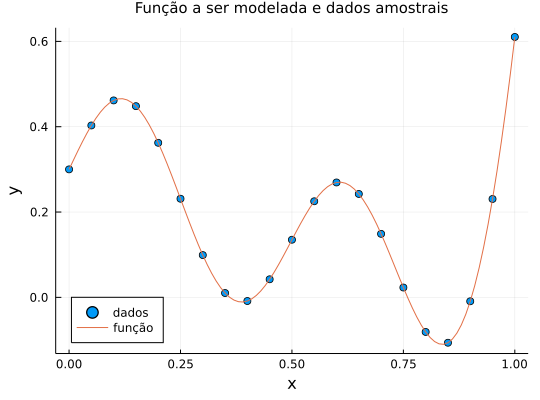

In [4]:
plot(data_x', data_y',
    seriestype=:scatter, size=(540,400), label="dados", legend=:bottomleft,
    xaxis = "x", yaxis = "y",
    title="Função a ser modelada e dados amostrais", titlefont=10)
plot!(0:0.01:1, f,
     size=(540,400), label="função")

### Preparando a rede e os dados

In [5]:
m = Chain(Dense(1, 4, σ), Dense(4,1))

Chain(Dense(1, 4, σ), Dense(4, 1))

In [6]:
m[1].weight[1:end] = [5.0, -5.0, -5.0, -5.0]
m[1].bias[1:end] = [-0.0, -0.0, 0.0, 0.0]
m[2].weight[1:end] = [5.0, -2.0, 5.0, -5.0]
m[2].bias[1:end] = [0.0]
nothing

### Preparando os dados

#### Para usar todos os dados de uma vez só, em cada época

In [7]:
data=[(data_x, data_y)]

1-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([0.0 0.05 … 0.95 1.0], [0.3 0.4029248465587088 … 0.2305995378278558 0.6103638323514327])

#### Para usar um dado de cada vez, em cada época

In [8]:
data_single = reshape([([x],[y]) for (x,y) in zip(data_x,data_y)], :, 1)

21×1 Matrix{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([0.0], [0.3])
 ([0.05], [0.4029248465587088])
 ([0.1], [0.4616315286698186])
 ([0.15], [0.4482034774365481])
 ([0.2], [0.3623122763818892])
 ([0.25], [0.23119882867142147])
 ([0.3], [0.09909941574602074])
 ([0.35], [0.010165529906583329])
 ([0.4], [-0.008571289448338962])
 ([0.45], [0.042361613778037294])
 ([0.5], [0.13508419791378998])
 ([0.55], [0.22521502482264072])
 ([0.6], [0.2693187940872386])
 ([0.65], [0.2423988800373355])
 ([0.7], [0.1488836415959175])
 ([0.75], [0.02305762207230444])
 ([0.8], [-0.0810623612233281])
 ([0.85], [-0.10635735492441278])
 ([0.9], [-0.009191405336851144])
 ([0.95], [0.2305995378278558])
 ([1.0], [0.6103638323514327])

#### Em lotes, um conjunto de dados, em vários passos, em cada época

In [9]:
batch_size = 7
data_batch = [
    (hcat(data_x[j:j+batch_size-1]...), hcat(data_y[j:j+batch_size-1]...))
    for j=1:batch_size:length(data_x)
]

3-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([0.0 0.05 … 0.25 0.3], [0.3 0.4029248465587088 … 0.23119882867142147 0.09909941574602074])
 ([0.35 0.4 … 0.6 0.65], [0.010165529906583329 -0.008571289448338962 … 0.2693187940872386 0.2423988800373355])
 ([0.7 0.75 … 0.95 1.0], [0.1488836415959175 0.02305762207230444 … 0.2305995378278558 0.6103638323514327])

### Preparando o treinamento

In [10]:
loss(x, y) = Flux.Losses.mse(m(x), y) # erro quadrático médio

opt = ADAM() # escolha do algoritmo 

function cb(i; istep = 1000) # função de call-back, executada a cada iteração
    if rem(i, istep) == 0
        @show i, loss(data_x,data_y)
    end
    return nothing
end

ps = Flux.params(m) # parâmetros a serem treinados: todos, nesse caso

Params([Float32[5.0; -5.0; -5.0; -5.0], Float32[-0.0, -0.0, 0.0, 0.0], Float32[5.0 -2.0 5.0 -5.0], Float32[0.0]])

### Método com todos os dados em cada época

In [11]:
n_epochs = 1_000
for i in 1:n_epochs
    Flux.train!(loss, ps, data, opt; cb = () -> cb(i, istep=200))
end

(i, loss(data_x, data_y)) = (200, 10.950452796156743)
(i, loss(data_x, data_y)) = (400, 7.904948970572502)
(i, loss(data_x, data_y)) = (600, 6.07257869356935)
(i, loss(data_x, data_y)) = (800, 4.884073546565871)
(i, loss(data_x, data_y)) = (1000, 3.9608816979112182)


### Método estocástico (um dado a cada passo)

In [12]:
n_epochs = 1_000
for i in 1:n_epochs
    Flux.train!(loss, ps, shuffle(data_single), opt; cb = () -> cb(i, istep=500))
end

(i, loss(data_x, data_y)) = (500, 0.026245890358537353)
(i, loss(data_x, data_y)) = (500, 0.026219818745067763)
(i, loss(data_x, data_y)) = (500, 0.026196920360364764)
(i, loss(data_x, data_y)) = (500, 0.02618823148895891)
(i, loss(data_x, data_y)) = (500, 0.026195320974895953)
(i, loss(data_x, data_y)) = (500, 0.026218997030025826)
(i, loss(data_x, data_y)) = (500, 0.026238810735990294)
(i, loss(data_x, data_y)) = (500, 0.02626063909200531)
(i, loss(data_x, data_y)) = (500, 0.026301057020887957)
(i, loss(data_x, data_y)) = (500, 0.026334072694270665)
(i, loss(data_x, data_y)) = (500, 0.02633924551606751)
(i, loss(data_x, data_y)) = (500, 0.026353971949298866)
(i, loss(data_x, data_y)) = (500, 0.026352622594764594)
(i, loss(data_x, data_y)) = (500, 0.026337883788377852)
(i, loss(data_x, data_y)) = (500, 0.02629650562886239)
(i, loss(data_x, data_y)) = (500, 0.026259751518877376)
(i, loss(data_x, data_y)) = (500, 0.02622412453586291)
(i, loss(data_x, data_y)) = (500, 0.02621054542047349

### Método estocástico em lotes

In [13]:
n_epochs = 1_000
for i in 1:n_epochs
    Flux.train!(loss, ps, shuffle(data_batch), opt; cb = () -> cb(i,istep=250))
end

(i, loss(data_x, data_y)) = (250, 0.024711754125653036)
(i, loss(data_x, data_y)) = (250, 0.024711867676142522)
(i, loss(data_x, data_y)) = (250, 0.02471160134884138)
(i, loss(data_x, data_y)) = (500, 0.024610183628857644)
(i, loss(data_x, data_y)) = (500, 0.02461002290238974)
(i, loss(data_x, data_y)) = (500, 0.02460984749046619)
(i, loss(data_x, data_y)) = (750, 0.024486709990869465)
(i, loss(data_x, data_y)) = (750, 0.024487263481110067)
(i, loss(data_x, data_y)) = (750, 0.02448692885283741)
(i, loss(data_x, data_y)) = (1000, 0.0243475712570216)
(i, loss(data_x, data_y)) = (1000, 0.024346746376742907)
(i, loss(data_x, data_y)) = (1000, 0.024346616022751205)


### Observação

* Nos últimos dois casos acima, a otimização, em cada passo, é feita apenas com os dados de cada lote, que muda passo a passo, dentro de cada época.

* Mas, apenas para fins de exibição, a função de custo é calculada em todos os pontos, para analisarmos o efeito da otimização no erro global.

### Usando o Dataloader

* O `DataLoader` nos poupa o trabalho de particionar os dados.

* Além dos dados, os outros argumentos para o método construtor do `Dataloader` são 
    * `batchsize=1`, que indica o tamanho do batch (*default* `1`)
    * `shuffle=true`, que embaralha as observações (antes de quebrar em lotes) a cada época (*default* `true`).
    * `partial=false`, que pode ou não descartar o último batch se for menor do que o `batchsize` desejado (*default* `false`).
    
* Também podemos combinar isso com o `IterTools.ncycle` para economizar um loop (isso está exemplificado no caderno sobre identificação de dígitos).

* Vamos ver o efeito dessas opções em uma sequência de dados.

In [14]:
test_loader = Flux.Data.DataLoader(1:10)
for a in test_loader
    println(a)
end

[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]


In [15]:
test_loader = Flux.Data.DataLoader(collect(1:10), batchsize=3)
for a in test_loader
    println(a)
end

[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10]


In [16]:
test_loader = Flux.Data.DataLoader(1:10, batchsize=3, partial=false)
for a in test_loader
    println(a)
end

[1, 2, 3]
[4, 5, 6]
[7, 8, 9]


In [17]:
test_loader = Flux.Data.DataLoader(1:10, batchsize=3, shuffle=true, partial=false)
for n in 1:4
    for a in test_loader
        println(a)
    end
    println()
end

[2, 4, 8]
[10, 6, 3]
[5, 7, 9]

[8, 2, 7]
[3, 9, 1]
[4, 10, 6]

[3, 8, 10]
[2, 4, 7]
[5, 9, 1]

[2, 9, 5]
[8, 10, 4]
[1, 7, 6]



In [18]:
for a in ncycle(test_loader, 4)
    println(a)
end

[8, 10, 5]
[3, 6, 9]
[7, 2, 1]
[2, 6, 4]
[9, 1, 10]
[7, 3, 8]
[6, 5, 1]
[4, 3, 10]
[8, 9, 2]
[8, 10, 9]
[1, 6, 4]
[2, 5, 3]


### Treinando usando o DataLoader

* Agora concluímos fazendo um último trainamento com o DataLoader

In [19]:
data_batch_loader = Flux.Data.DataLoader((data_x, data_y), batchsize=3)

n_epochs = 2_000
for i in 1:n_epochs
    Flux.train!(loss, ps, data_batch_loader, opt, cb = () -> cb(i, istep=500))
end

(i, loss(data_x, data_y)) = (500, 0.02405519468044572)
(i, loss(data_x, data_y)) = (500, 0.024055321285907223)
(i, loss(data_x, data_y)) = (500, 0.0240551926815859)
(i, loss(data_x, data_y)) = (500, 0.024055440716238226)
(i, loss(data_x, data_y)) = (500, 0.024054931257489094)
(i, loss(data_x, data_y)) = (500, 0.024054834283253744)
(i, loss(data_x, data_y)) = (500, 0.024054774726692374)
(i, loss(data_x, data_y)) = (1000, 0.023863326042311957)
(i, loss(data_x, data_y)) = (1000, 0.023863461468694395)
(i, loss(data_x, data_y)) = (1000, 0.023863343702646783)
(i, loss(data_x, data_y)) = (1000, 0.02386358398325541)
(i, loss(data_x, data_y)) = (1000, 0.023863119302846406)
(i, loss(data_x, data_y)) = (1000, 0.023863036209071493)
(i, loss(data_x, data_y)) = (1000, 0.02386298959389392)
(i, loss(data_x, data_y)) = (1500, 0.023708599071280895)
(i, loss(data_x, data_y)) = (1500, 0.023708742447579517)
(i, loss(data_x, data_y)) = (1500, 0.023708631637916016)
(i, loss(data_x, data_y)) = (1500, 0.023708

### Visualizando o resultado

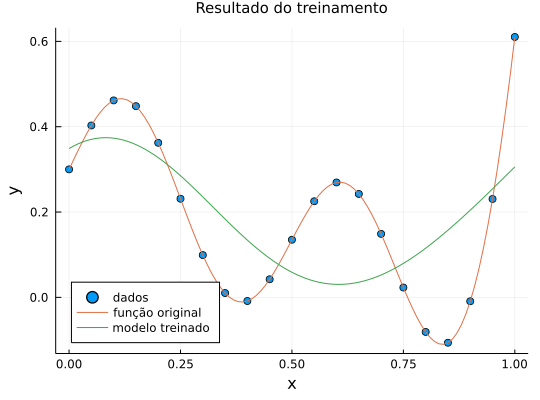

In [20]:
plot(data_x', data_y',
    seriestype=:scatter, size=(540,400), label="dados", legend=:bottomleft,
    xaxis = "x", yaxis = "y",
    title="Resultado do treinamento", titlefont=10)
plot!(0:0.01:1, f, size=(540,400), label="função original")
plot!(0:0.01:1, m(reshape(collect(0:0.01:1), 1, :))',
    size=(540,400), label="modelo treinado", legend=:bottomleft)

### Completando

* Vamos tentar resolver com mais passos

In [21]:
n_epochs = 40_000
for i in 1:n_epochs
    Flux.train!(loss, ps, 
        Flux.Data.DataLoader((data_x, data_y), batchsize=7),
        opt, cb = () -> cb(i, istep=10000))
end

(i, loss(data_x, data_y)) = (10000, 0.022902967652587283)
(i, loss(data_x, data_y)) = (10000, 0.02290307325626783)
(i, loss(data_x, data_y)) = (10000, 0.022902923421780418)
(i, loss(data_x, data_y)) = (20000, 0.02277948436190147)
(i, loss(data_x, data_y)) = (20000, 0.022779594741419974)
(i, loss(data_x, data_y)) = (20000, 0.02277944066203052)
(i, loss(data_x, data_y)) = (30000, 0.022665248098877197)
(i, loss(data_x, data_y)) = (30000, 0.0226653576382053)
(i, loss(data_x, data_y)) = (30000, 0.022665200469833627)
(i, loss(data_x, data_y)) = (40000, 0.022561525654406705)
(i, loss(data_x, data_y)) = (40000, 0.022561633719492456)
(i, loss(data_x, data_y)) = (40000, 0.02256147423735087)


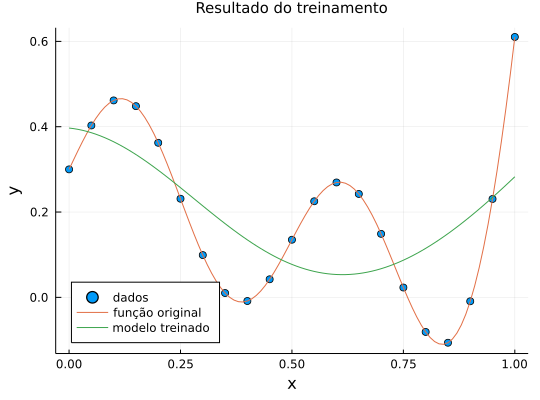

In [22]:
plot(data_x', data_y',
    seriestype=:scatter, size=(540,400), label="dados", legend=:bottomleft,
    xaxis = "x", yaxis = "y",
    title="Resultado do treinamento", titlefont=10)
plot!(0:0.01:1, f, size=(540,400), label="função original")
plot!(0:0.01:1, m(reshape(collect(0:0.01:1), 1, :))',
    size=(540,400), label="modelo treinado", legend=:bottomleft)

### Retornando com todos os dados

* Aparentemente não temos um número suficiente de dados pra otimizar em lotes.

* Vamos retornar com todos os dados

In [23]:
n_epochs = 40_000
for i in 1:n_epochs
    Flux.train!(loss, ps, data, opt, cb = () -> cb(i, istep=10000))
end

(i, loss(data_x, data_y)) = (10000, 0.021963086577450507)
(i, loss(data_x, data_y)) = (20000, 0.017027836981139344)
(i, loss(data_x, data_y)) = (30000, 0.003153246849428255)
(i, loss(data_x, data_y)) = (40000, 0.001658828605979054)


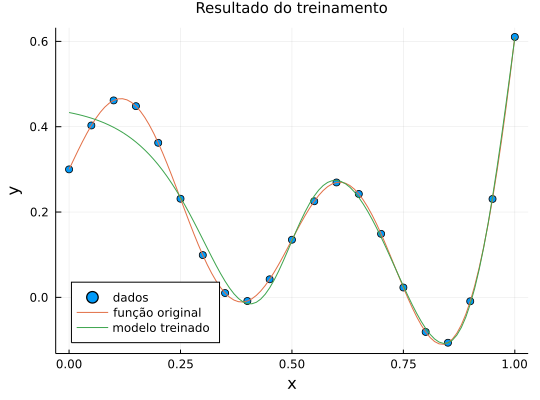

In [24]:
plot(data_x', data_y',
    seriestype=:scatter, size=(540,400), label="dados", legend=:bottomleft,
    xaxis = "x", yaxis = "y",
    title="Resultado do treinamento", titlefont=10)
plot!(0:0.01:1, f, size=(540,400), label="função original")
plot!(0:0.01:1, m(reshape(collect(0:0.01:1), 1, :))',
    size=(540,400), label="modelo treinado", legend=:bottomleft)

<!--NAVIGATOR-->

---
[<- 5. Treinando redes neurais](05.00-Treinando_redes_neurais.ipynb) | [Página inicial](00.00-Pagina_inicial.ipynb) | [7. Identificação de dígitos com os dados MNIST ->](07.00-Reconhecimento_digitos.ipynb)